In [19]:

# provide project root path
ProjectRoot = ""
DatasetRoot = ProjectRoot + "manuals/"

In [20]:
try:
    import chromadb
except ImportError:
    !pip install chromadb

try:
    import sentence_transformers
except ImportError:
    !pip install -U sentence-transformers

try:
    import rank_bm25
except ImportError:
    !pip install rank_bm25

try:
    import seaborn
except ImportError:
    !pip install seaborn

In [21]:
import chromadb
from sentence_transformers import SentenceTransformer
# misc
import json
import regex as re
import numpy as np
import pandas as pd
# viz
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# loading full article from json file
df = None
file_path = DatasetRoot + '/Fraggles_X700_2022_HCM_QA_Curated.csv'
df = pd.read_csv(file_path,  encoding='latin1')

#keep only one question per chunk
df.dropna(subset=['question', 'answer'], inplace=True)
df = df.drop_duplicates(subset=['para_id'], keep='first')
df = df.reset_index(drop=False)  # Adds the index as a new column
df =df.reset_index(drop=False)
df = df.rename(columns={"level_0": "para_id_index"})
raw_text_list = df['sentence_chunk']
raw_text_ids = df['para_id_index']



In [23]:
df.head()

,para_id_index,index,page_number,para_id,sentence_chunk,question,answer
0,0,0,1,e6c45229dc996b6ba2ecb9ddb251f77c5ee3f2de93cc1d...,check that the rod is ï¬rmly placed to avoid ...,What should you do to prevent the hood from ac...,"Before closing the hood, make sure the support..."
1,1,3,1,69dedd5e3d5bbf7c8e9a12176d60789e110a65cd533d26...,"If you feel any resistance, stop and check fo...",What should you do if you feel resistance when...,"f you feel any resistance, stop immediately an..."
2,2,6,1,fc843f5ed9e92f0a42868ed7813e7c197902b5f2194f87...,Pull the hood release handle: The hood release...,Where is the hood release handle typically loc...,The hood release handle is usually located in ...
3,3,9,1,0c927bca6c80fe20d270cb43d62ea95099483181509007...,The support rod is typically located on the u...,Where is the support rod typically located in ...,The support rod is typically located on the un...
4,4,12,2,560865acae00a7a1c7b35d8567b972195079a68eddcf40...,Genuine FragglesX700HCM Motor Oil (for optimal...,What are the benefits of using Genuine Fraggle...,Genuine FragglesX700HCM Motor Oil is a premium...


In [24]:
# dataframe holding metrics for different embeddings
embeddings_metrics_df = pd.DataFrame(columns=['Embedding', 'Precision', 'Recall', 'MRR'])

# calculate Retrieval Precision, Recall, MRR
def evaluate_retrieval(embed_model, retriever, eval_dataset, top_n=3):
    precision_at_k = []
    recall_at_k = []
    mrr = []

    for _, eval_data in eval_dataset.iterrows():

        # get query and raw paragraph ID from where question was generated.
        # This paragraph will be treated as ground truth doc
        raw_para_id = eval_data['para_id_index']
        query = eval_data['question']

        # embed query into vector
        query_embedding = embed_model.encode(query).tolist()
        # search most relevant docs
        retrieved_docs = retriever.query(query_embeddings=query_embedding, n_results=top_n)
        doc_indices = [int(idx) for idx in retrieved_docs['ids'][0]]

        relevant_docs = set([raw_para_id])
        retrieved_docs = set(doc_indices)

        hits = relevant_docs & retrieved_docs

        # calculate precision, recall
        precision = len(hits) / len(retrieved_docs)
        recall = len(hits) / len(relevant_docs)

        precision_at_k.append(precision)
        recall_at_k.append(recall)

        # calculate MRR
        reciprocal_rank = 0.0
        for rank, doc_index in enumerate(doc_indices, start=1):
            if doc_index in relevant_docs:
                reciprocal_rank = 1.0 / rank
                break
        mrr.append(reciprocal_rank)

    avg_precision = np.mean(precision_at_k)
    avg_recall = np.mean(recall_at_k)
    avg_mrr = np.mean(mrr)

    return avg_precision, avg_recall, avg_mrr

Eval BM25 baseline
https://pypi.org/project/rank-bm25/

In [25]:

from rank_bm25 import BM25Okapi

model_name = 'BM25'

tokenized_corpus = [doc.split(" ") for doc in raw_text_list]  # Tokenize raw documents
bm25_retriever = BM25Okapi(tokenized_corpus)

In [26]:
import numpy as np

def evaluate_retrieval_bm25(bm25, eval_dataset, top_n=3):
    precision_at_k = []
    recall_at_k = []
    mrr = []

    for _, eval_data in eval_dataset.iterrows():
        # Get query and raw paragraph ID (ground truth doc)
        raw_para_id = eval_data['para_id_index']
        query = eval_data['question']

        # Search for the most relevant documents using BM25
        scores = bm25.get_scores(query)
        sorted_doc_indices = np.argsort(-scores)[:top_n]

        # Set of relevant documents and retrieved documents
        relevant_docs = set([raw_para_id])  # For a single relevant doc
        retrieved_docs = set(sorted_doc_indices)

        # print(relevant_docs)
        # print('retrieved_docs: ', retrieved_docs)

        hits = relevant_docs & retrieved_docs  # Intersection of relevant and retrieved docs

        # Calculate Precision and Recall
        precision = len(hits) / len(retrieved_docs) if len(retrieved_docs) > 0 else 0.0
        recall = len(hits) / len(relevant_docs) if len(relevant_docs) > 0 else 0.0

        precision_at_k.append(precision)
        recall_at_k.append(recall)

        # Calculate MRR (Mean Reciprocal Rank)
        reciprocal_rank = 0.0
        for rank, doc_index in enumerate(sorted_doc_indices, start=1):
            if doc_index in relevant_docs:
                reciprocal_rank = 1.0 / rank
                break
        mrr.append(reciprocal_rank)

    # Calculate average metrics
    avg_precision = np.mean(precision_at_k)
    avg_recall = np.mean(recall_at_k)
    avg_mrr = np.mean(mrr)

    return avg_precision, avg_recall, avg_mrr


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89 entries, 0 to 88
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   para_id_index   89 non-null     int64 
 1   index           89 non-null     int64 
 2   page_number     89 non-null     int64 
 3   para_id         89 non-null     object
 4   sentence_chunk  89 non-null     object
 5   question        89 non-null     object
 6   answer          89 non-null     object
dtypes: int64(3), object(4)
memory usage: 5.0+ KB


In [28]:


# calculate precision, recall, mrr
precision, recall, mrr = evaluate_retrieval_bm25(bm25_retriever, df[['para_id_index', 'question']])

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, MRR: {mrr:.4f}")

# record results
new_row = pd.DataFrame({
    'Embedding': [model_name],
    'Precision': [precision],
    'Recall': [recall],
    'MRR': [mrr]
})
embeddings_metrics_df = pd.concat([embeddings_metrics_df, new_row], ignore_index=True)

Precision: 0.0112, Recall: 0.0337, MRR: 0.0206


/tmp/ipykernel_550471/219080959.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  embeddings_metrics_df = pd.concat([embeddings_metrics_df, new_row], ignore_index=True)


In [29]:
import concurrent.futures
from sentence_transformers import SentenceTransformer
import chromadb
import pandas as pd
import torch

# List of models to evaluate
models = [
    'sentence-transformers/all-mpnet-base-v2',
    'sentence-transformers/all-MiniLM-L6-v2',
    'sentence-transformers/average_word_embeddings_glove.840B.300d',
    'sentence-transformers/multi-qa-mpnet-base-dot-v1',
    'sentence-transformers/multi-qa-mpnet-base-cos-v1',
    'sentence-transformers/all-distilroberta-v1',
    'colbert-ir/colbertv2.0'
]

# Loop over models and evaluate each one
for model_name in models:
    # Sentence transformer models
    model = SentenceTransformer(model_name)
    embeddings = [model.encode(text).tolist() for text in raw_text_list]
    
    # Setup Chroma client and collection
    #client = chromadb.Client()
    client = chromadb.PersistentClient(path='chroma_db_dir')

    collectionname = model_name.replace('sentence-transformers/', '')
    collection_name = f"knowledge-store-{re.sub('[^a-zA-Z]', '', collectionname)}"

    retriever = client.get_or_create_collection(collection_name)

    raw_text_ids = raw_text_ids.astype(str)

    # Add documents and embeddings to the collection
    retriever.add(
        embeddings=embeddings,
        documents=raw_text_list.tolist(),
        ids=raw_text_ids.tolist()
    )
    
    # Evaluate retrieval performance using the evaluate_retrieval function
    precision, recall, mrr = evaluate_retrieval(model, retriever, df[['para_id_index', 'question']])

    print(model_name, precision, recall, mrr)
    
    # Append results to DataFrame
    new_row = pd.DataFrame({
        'Embedding': [model_name],
        'Precision': [precision],
        'Recall': [recall],
        'MRR': [mrr]
    })
    embeddings_metrics_df = pd.concat([embeddings_metrics_df, new_row], ignore_index=True)

# Print the results after all models have been evaluated
print(embeddings_metrics_df)



Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding ID: 21
Add of existing embedding ID: 22
Add of existing embedding ID: 23
Add of existing embedding ID: 24
Add of existing embedding ID: 25
Add of existing embedding ID: 26
Add of existing embedding ID: 27
Add of existing embedding ID: 28
Add of existing embedding ID: 29
Add of existing embe

sentence-transformers/all-mpnet-base-v2 0.250936329588015 0.7528089887640449 0.5917602996254682


Insert of existing embedding ID: 0
Insert of existing embedding ID: 1
Insert of existing embedding ID: 2
Insert of existing embedding ID: 3
Insert of existing embedding ID: 4
Insert of existing embedding ID: 5
Insert of existing embedding ID: 6
Insert of existing embedding ID: 7
Insert of existing embedding ID: 8
Insert of existing embedding ID: 9
Insert of existing embedding ID: 10
Insert of existing embedding ID: 11
Insert of existing embedding ID: 12
Insert of existing embedding ID: 13
Insert of existing embedding ID: 14
Insert of existing embedding ID: 15
Insert of existing embedding ID: 16
Insert of existing embedding ID: 17
Insert of existing embedding ID: 18
Insert of existing embedding ID: 19
Insert of existing embedding ID: 20
Insert of existing embedding ID: 21
Insert of existing embedding ID: 22
Insert of existing embedding ID: 23
Insert of existing embedding ID: 24
Insert of existing embedding ID: 25
Insert of existing embedding ID: 26
Insert of existing embedding ID: 27
In

sentence-transformers/all-MiniLM-L6-v2 0.2771535580524344 0.8314606741573034 0.651685393258427


Insert of existing embedding ID: 0
Insert of existing embedding ID: 1
Insert of existing embedding ID: 2
Insert of existing embedding ID: 3
Insert of existing embedding ID: 4
Insert of existing embedding ID: 5
Insert of existing embedding ID: 6
Insert of existing embedding ID: 7
Insert of existing embedding ID: 8
Insert of existing embedding ID: 9
Insert of existing embedding ID: 10
Insert of existing embedding ID: 11
Insert of existing embedding ID: 12
Insert of existing embedding ID: 13
Insert of existing embedding ID: 14
Insert of existing embedding ID: 15
Insert of existing embedding ID: 16
Insert of existing embedding ID: 17
Insert of existing embedding ID: 18
Insert of existing embedding ID: 19
Insert of existing embedding ID: 20
Insert of existing embedding ID: 21
Insert of existing embedding ID: 22
Insert of existing embedding ID: 23
Insert of existing embedding ID: 24
Insert of existing embedding ID: 25
Insert of existing embedding ID: 26
Insert of existing embedding ID: 27
In

sentence-transformers/average_word_embeddings_glove.840B.300d 0.16104868913857676 0.48314606741573035 0.35580524344569286


Insert of existing embedding ID: 0
Insert of existing embedding ID: 1
Insert of existing embedding ID: 2
Insert of existing embedding ID: 3
Insert of existing embedding ID: 4
Insert of existing embedding ID: 5
Insert of existing embedding ID: 6
Insert of existing embedding ID: 7
Insert of existing embedding ID: 8
Insert of existing embedding ID: 9
Insert of existing embedding ID: 10
Insert of existing embedding ID: 11
Insert of existing embedding ID: 12
Insert of existing embedding ID: 13
Insert of existing embedding ID: 14
Insert of existing embedding ID: 15
Insert of existing embedding ID: 16
Insert of existing embedding ID: 17
Insert of existing embedding ID: 18
Insert of existing embedding ID: 19
Insert of existing embedding ID: 20
Insert of existing embedding ID: 21
Insert of existing embedding ID: 22
Insert of existing embedding ID: 23
Insert of existing embedding ID: 24
Insert of existing embedding ID: 25
Insert of existing embedding ID: 26
Insert of existing embedding ID: 27
In

sentence-transformers/multi-qa-mpnet-base-dot-v1 0.25468164794007486 0.7640449438202247 0.6198501872659176


Insert of existing embedding ID: 0
Insert of existing embedding ID: 1
Insert of existing embedding ID: 2
Insert of existing embedding ID: 3
Insert of existing embedding ID: 4
Insert of existing embedding ID: 5
Insert of existing embedding ID: 6
Insert of existing embedding ID: 7
Insert of existing embedding ID: 8
Insert of existing embedding ID: 9
Insert of existing embedding ID: 10
Insert of existing embedding ID: 11
Insert of existing embedding ID: 12
Insert of existing embedding ID: 13
Insert of existing embedding ID: 14
Insert of existing embedding ID: 15
Insert of existing embedding ID: 16
Insert of existing embedding ID: 17
Insert of existing embedding ID: 18
Insert of existing embedding ID: 19
Insert of existing embedding ID: 20
Insert of existing embedding ID: 21
Insert of existing embedding ID: 22
Insert of existing embedding ID: 23
Insert of existing embedding ID: 24
Insert of existing embedding ID: 25
Insert of existing embedding ID: 26
Insert of existing embedding ID: 27
In

sentence-transformers/multi-qa-mpnet-base-cos-v1 0.2696629213483146 0.8089887640449438 0.6779026217228464


Add of existing embedding ID: 0
Add of existing embedding ID: 1
Add of existing embedding ID: 2
Add of existing embedding ID: 3
Add of existing embedding ID: 4
Add of existing embedding ID: 5
Add of existing embedding ID: 6
Add of existing embedding ID: 7
Add of existing embedding ID: 8
Add of existing embedding ID: 9
Add of existing embedding ID: 10
Add of existing embedding ID: 11
Add of existing embedding ID: 12
Add of existing embedding ID: 13
Add of existing embedding ID: 14
Add of existing embedding ID: 15
Add of existing embedding ID: 16
Add of existing embedding ID: 17
Add of existing embedding ID: 18
Add of existing embedding ID: 19
Add of existing embedding ID: 20
Add of existing embedding ID: 21
Add of existing embedding ID: 22
Add of existing embedding ID: 23
Add of existing embedding ID: 24
Add of existing embedding ID: 25
Add of existing embedding ID: 26
Add of existing embedding ID: 27
Add of existing embedding ID: 28
Add of existing embedding ID: 29
Add of existing embe

sentence-transformers/all-distilroberta-v1 0.24719101123595505 0.7415730337078652 0.5898876404494382


Insert of existing embedding ID: 0
Insert of existing embedding ID: 1
Insert of existing embedding ID: 2
Insert of existing embedding ID: 3
Insert of existing embedding ID: 4
Insert of existing embedding ID: 5
Insert of existing embedding ID: 6
Insert of existing embedding ID: 7
Insert of existing embedding ID: 8
Insert of existing embedding ID: 9
Insert of existing embedding ID: 10
Insert of existing embedding ID: 11
Insert of existing embedding ID: 12
Insert of existing embedding ID: 13
Insert of existing embedding ID: 14
Insert of existing embedding ID: 15
Insert of existing embedding ID: 16
Insert of existing embedding ID: 17
Insert of existing embedding ID: 18
Insert of existing embedding ID: 19
Insert of existing embedding ID: 20
Insert of existing embedding ID: 21
Insert of existing embedding ID: 22
Insert of existing embedding ID: 23
Insert of existing embedding ID: 24
Insert of existing embedding ID: 25
Insert of existing embedding ID: 26
Insert of existing embedding ID: 27
In

colbert-ir/colbertv2.0 0.19850187265917602 0.5955056179775281 0.4681647940074906
                                           Embedding  Precision    Recall  \
0                                               BM25   0.011236  0.033708   
1            sentence-transformers/all-mpnet-base-v2   0.250936  0.752809   
2             sentence-transformers/all-MiniLM-L6-v2   0.277154  0.831461   
3  sentence-transformers/average_word_embeddings_...   0.161049  0.483146   
4   sentence-transformers/multi-qa-mpnet-base-dot-v1   0.254682  0.764045   
5   sentence-transformers/multi-qa-mpnet-base-cos-v1   0.269663  0.808989   
6         sentence-transformers/all-distilroberta-v1   0.247191  0.741573   
7                             colbert-ir/colbertv2.0   0.198502  0.595506   

        MRR  
0  0.020599  
1  0.591760  
2  0.651685  
3  0.355805  
4  0.619850  
5  0.677903  
6  0.589888  
7  0.468165  


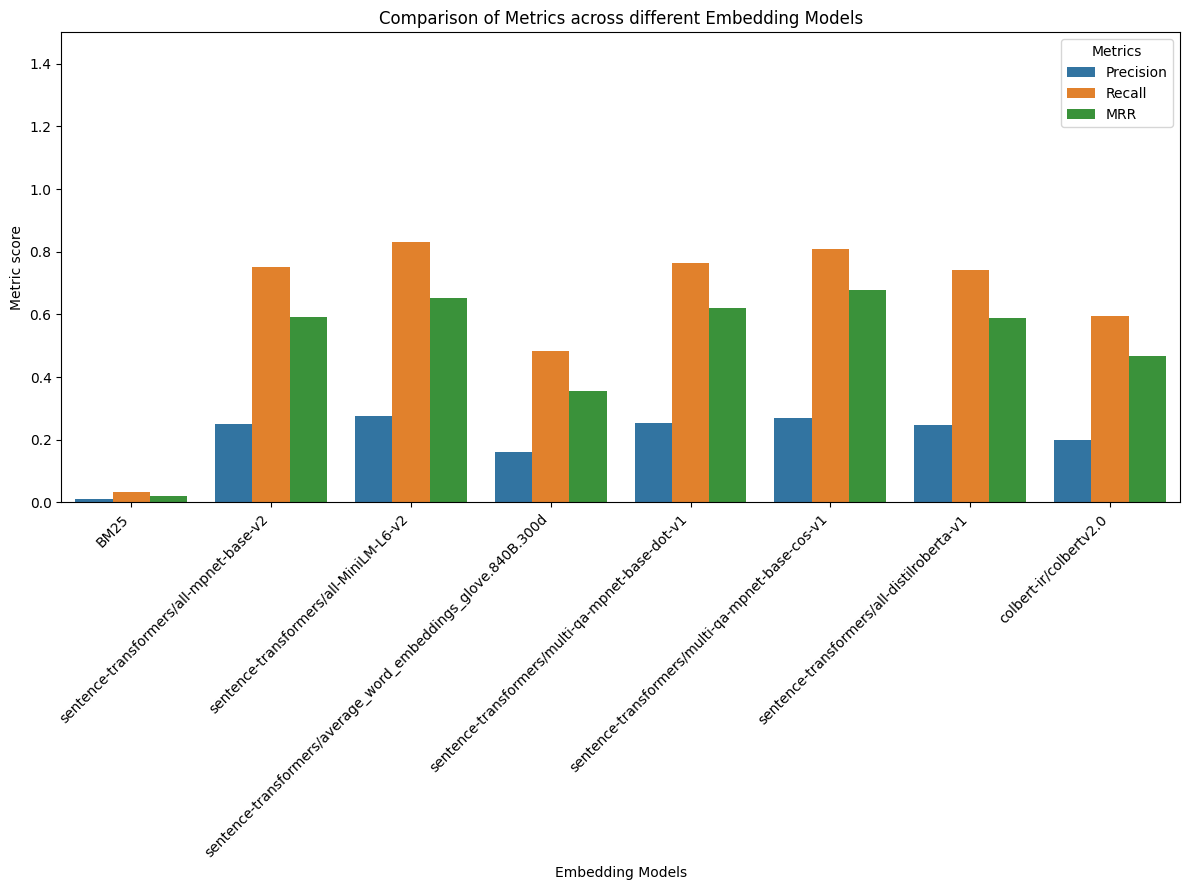

In [30]:
# melt df to plot Precision, Recall, MRR
melted_df = embeddings_metrics_df.melt(id_vars='Embedding', var_name='Metric', value_name='Value')

# Plot
plt.figure(figsize=(12, 9))
sns.barplot(data=melted_df, x='Embedding', y='Value', hue='Metric')
plt.title('Comparison of Metrics across different Embedding Models')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Embedding Models')
plt.ylabel('Metric score')
plt.ylim(0.0, 1.5)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()